# Imports and paths

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import os
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
import glob
import torch.optim as optim
from tqdm import tqdm
import sys
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
from timm.models import create_model as timm_create_model
from torchvision.models import vit_b_16, swin_t # For ViT and Swin Transformer models

# Paths for each view (update these paths with the correct file locations)
train_axial_path = 'train/axial/'
valid_axial_path = 'valid/axial/'
train_coronal_path = 'train/coronal/'
valid_coronal_path = 'valid/coronal/'
train_sagittal_path = 'train/sagittal/'
valid_sagittal_path = 'valid/sagittal/'

# CSV paths for labels (update these paths with the correct file locations)
train_labels_abnormal = 'train-abnormal.csv'
valid_labels_abnormal = 'valid-abnormal.csv'
train_labels_acl = 'train-acl.csv'
valid_labels_acl = 'valid-acl.csv'
train_labels_meniscus = 'train-meniscus.csv'
valid_labels_meniscus = 'valid-meniscus.csv'

# Class for my MRIDataset

In [2]:
class MRIDataset(Dataset):
    def __init__(self, axial_path, coronal_path, sagittal_path, abnormal_labels_path, acl_labels_path, meniscus_labels_path, transform=None):
        # Collecting all file paths for each orientation into one list
        self.all_images = sorted(glob.glob(os.path.join(axial_path, '*.npy')) +
                                 glob.glob(os.path.join(coronal_path, '*.npy')) +
                                 glob.glob(os.path.join(sagittal_path, '*.npy')))
        self.transform = transform

        # Load labels
        abnormal_labels = pd.read_csv(abnormal_labels_path, header=None)[1].to_numpy()
        acl_labels = pd.read_csv(acl_labels_path, header=None)[1].to_numpy()
        meniscus_labels = pd.read_csv(meniscus_labels_path, header=None)[1].to_numpy()

        # Stack labels to create a (num_samples, 3) array (1 label per sample)
        self.labels = np.vstack((abnormal_labels, acl_labels, meniscus_labels)).T

    def __len__(self):
        # The length of the dataset is the total number of images (across all orientations)
        return len(self.all_images)

    def __getitem__(self, idx):
        # Load the image from the unified list of all images
        image = np.load(self.all_images[idx])

        # Take the middle slice if images have 3 dimensions
        def middle_slice(image):
            return image[image.shape[0] // 2] if image.ndim == 3 else image

        image = middle_slice(image)

        # Convert the image to PIL format and apply transformations if any
        image = Image.fromarray((image * 255).astype(np.uint8))  # Rescale to [0, 255] for display
        if self.transform:
            image = self.transform(image)  # Apply any transform passed

        # For labels, we return the label corresponding to the current index
        label = torch.tensor(self.labels[idx % len(self.labels)], dtype=torch.float32)

        return image, label

# Preprocessing and augmentation transforms

In [3]:
preprocess_transforms = transforms.Compose([
    transforms.Resize((224, 224)),              # Resize to 224x224
    transforms.Lambda(lambda x: x.convert("RGB")),  # Convert 1 channel to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Additional augmentation transforms
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=10),           # Randomly rotate image by up to 10 degrees
    transforms.RandomHorizontalFlip(),               # Randomly flip horizontally
    preprocess_transforms                            # Apply preprocessing after augmentations
])

# Train dataset

In [4]:
# Initialize Dataset with augmentation transforms for training
train_dataset = MRIDataset(
    axial_path=train_axial_path, coronal_path=train_coronal_path, sagittal_path=train_sagittal_path,
    abnormal_labels_path=train_labels_abnormal, acl_labels_path=train_labels_acl, meniscus_labels_path=train_labels_meniscus,
    transform=augmentation_transforms
)

# Initialize DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


# Valid Dataset

In [5]:
valid_dataset = MRIDataset(
    axial_path=valid_axial_path, coronal_path=valid_coronal_path, sagittal_path=valid_sagittal_path,
    abnormal_labels_path=valid_labels_abnormal, acl_labels_path=valid_labels_acl, meniscus_labels_path=valid_labels_meniscus,
    transform=preprocess_transforms
)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

# Pretrained model

In [6]:
def create_model(model_name, num_classes=3, pretrained=True):
    if model_name == "resnet18":
        model = models.resnet18(pretrained=pretrained)
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    elif model_name == "resnet34":
        model = models.resnet34(pretrained=pretrained)
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    elif model_name == "efficientnet_b0":
        model = EfficientNet.from_pretrained("efficientnet-b0")
        num_features = model._fc.in_features
        model._fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    elif model_name == "vit_b_16":
        model = vit_b_16(pretrained=pretrained)
        num_features = model.heads.head.in_features
        model.heads.head = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
    )
    elif model_name == "swin_t":
        model = swin_t(pretrained=pretrained)
        num_features = model.head.in_features
        model.head = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    elif model_name == "dino_vit_small":
        model = timm_create_model("vit_small_patch16_224", pretrained=True)
        num_features = model.head.in_features
        model.head = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    else:
        raise ValueError(f"Model {model_name} not supported!")
    return model

# Training and validation loop

In [7]:
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []
val_roc_aucs = []

def train_epoch(model, dataloader, optimizer, criterion, epoch, device):
    model.train()
    total_train_loss = 0.0
    dataset_size = 0

    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)
    for step, (images, labels) in bar:
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        pred = model(images)

        # Compute loss
        loss = criterion(pred, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track training loss
        total_train_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = total_train_loss / dataset_size
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss)

    train_losses.append(epoch_loss)
    return epoch_loss


In [8]:
def valid_epoch(model, dataloader, criterion, epoch, device):
    model.eval()
    total_val_loss = 0.0
    dataset_size = 0
    correct = 0
    all_labels = []
    all_preds = []
    all_probs = []

    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)
    for step, (images, labels) in bar:
        images = images.to(device)
        labels = labels.to(device).float()

        batch_size = images.shape[0]

        with torch.no_grad():
            pred = model(images)
            loss = criterion(pred, labels)

            # Collect predictions and probabilities for metrics
            probabilities = torch.sigmoid(pred)
            predictions = (probabilities > 0.5).int()

            all_probs.append(probabilities.cpu())
            all_preds.append(predictions.cpu())
            all_labels.append(labels.cpu())

            correct += (predictions == labels.int()).sum().item()
            total_val_loss += (loss.item() * batch_size)
            dataset_size += batch_size

        epoch_loss = total_val_loss / dataset_size
        accuracy = 100 * correct / (dataset_size * labels.size(1))

        bar.set_postfix(Epoch=epoch, Valid_Acc=accuracy, Valid_Loss=epoch_loss)

    # Compute metrics
    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_probs = torch.cat(all_probs).numpy()

    accuracy = accuracy_score(all_labels.flatten(), all_preds.flatten())
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    roc_auc = roc_auc_score(all_labels, all_probs, average='macro')

    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1s.append(f1)
    val_roc_aucs.append(roc_auc)

    print(f"Validation Metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
    return accuracy, epoch_loss

In [9]:
def run_training(model, criterion, trainloader, testloader, optimizer, num_epochs, device):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    top_accuracy = 0.0

    for epoch in range(num_epochs):
        train_loss = train_epoch(model, trainloader, optimizer, criterion, epoch, device)

        with torch.no_grad():
            val_accuracy, val_loss = valid_epoch(model, testloader, criterion, epoch, device)
            if val_accuracy > top_accuracy:
                print(f"Validation Accuracy Improved ({top_accuracy:.4f} ---> {val_accuracy:.4f})")
                top_accuracy = val_accuracy

        print()

# Testing and Evaluation

In [10]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_labels, all_outputs = [], []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            all_labels.append(labels.cpu())
            all_outputs.append(outputs.cpu())
    
    all_labels = torch.cat(all_labels).numpy()
    all_outputs = torch.cat(all_outputs).numpy()
    all_outputs = 1 / (1 + np.exp(-all_outputs))  # Apply sigmoid

    # Convert outputs to binary predictions
    predictions = (all_outputs > 0.5)

    # Calculate multi-label accuracy
    correct = (predictions == all_labels).sum()
    total = np.prod(all_labels.shape)  # Total number of elements
    accuracy = correct / total

    f1 = f1_score(all_labels, predictions, average='macro')
    roc_auc = roc_auc_score(all_labels, all_outputs, average='macro')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")


# Run evaluation


[INFO] Training resnet18...



/home/eduardo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eduardo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[INFO] Epoch 1/10 for resnet18
100%|██████████| 6/6 [00:03<00:00,  1.51it/s, Epoch=0, Valid_Acc=69.1, Valid_Loss=0.589]
Validation Metrics - Accuracy: 0.6907, Precision: 0.5232, Recall: 0.4790, F1: 0.4889, ROC-AUC: 0.7762

[INFO] Epoch 2/10 for resnet18
100%|██████████| 6/6 [00:00<00:00, 10.28it/s, Epoch=1, Valid_Acc=69, Valid_Loss=0.574]  
Validation Metrics - Accuracy: 0.6898, Precision: 0.8619, Recall: 0.4547, F1: 0.4873, ROC-AUC: 0.8102

[INFO] Epoch 3/10 for resnet18
100%|██████████| 6/6 [00:00<00:00,  9.68it/s, Epoch=2, Valid_Acc=71.6, Valid_Loss=0.56] 
Validation Metrics - Accuracy: 0.7157, Precision: 0.8323, Recall: 0.5537, F1: 0.5888, ROC-AUC: 0.8229

[INFO] Epoch 4/10 for resnet18
100%|██████████| 6/6 [00:00<00:00,  9.69it/s, Epoch=3, Valid_Acc=73.8, Valid_Loss=0.537]
Validation Metrics - Accuracy: 0.7380, Precision: 0.8179, Recall: 0.5866, F1: 0.6512, ROC-AUC: 0.8226

[INFO] Epoch 5/10 for resnet18
100%|██████████| 6/6 [00:00<00:00,  9.73it/s, Epoch=4, Valid_Acc=76.7, Valid

/home/eduardo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eduardo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[INFO] Epoch 1/10 for vit_b_16
100%|██████████| 6/6 [00:16<00:00,  2.83s/it, Epoch=0, Valid_Acc=64.5, Valid_Loss=0.637]
Validation Metrics - Accuracy: 0.6454, Precision: 0.4965, Recall: 0.3675, F1: 0.3546, ROC-AUC: 0.7524

[INFO] Epoch 2/10 for vit_b_16
100%|██████████| 6/6 [00:17<00:00,  2.85s/it, Epoch=1, Valid_Acc=66.8, Valid_Loss=0.613]
Validation Metrics - Accuracy: 0.6676, Precision: 0.7957, Recall: 0.5555, F1: 0.5074, ROC-AUC: 0.7945

[INFO] Epoch 3/10 for vit_b_16
100%|██████████| 6/6 [00:16<00:00,  2.83s/it, Epoch=2, Valid_Acc=67.2, Valid_Loss=0.601]
Validation Metrics - Accuracy: 0.6722, Precision: 0.8438, Recall: 0.4398, F1: 0.4515, ROC-AUC: 0.7582

[INFO] Epoch 4/10 for vit_b_16
100%|██████████| 6/6 [00:16<00:00,  2.81s/it, Epoch=3, Valid_Acc=68.1, Valid_Loss=0.609]
Validation Metrics - Accuracy: 0.6815, Precision: 0.8482, Recall: 0.4457, F1: 0.4661, ROC-AUC: 0.8037

[INFO] Epoch 5/10 for vit_b_16
100%|██████████| 6/6 [00:17<00:00,  2.84s/it, Epoch=4, Valid_Acc=72.2, Valid

/home/eduardo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eduardo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_T_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_T_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[INFO] Epoch 1/10 for swin_t
100%|██████████| 6/6 [00:03<00:00,  1.73it/s, Epoch=0, Valid_Acc=65, Valid_Loss=0.648]  
Validation Metrics - Accuracy: 0.6500, Precision: 0.5621, Recall: 0.3697, F1: 0.3593, ROC-AUC: 0.6634

[INFO] Epoch 2/10 for swin_t
100%|██████████| 6/6 [00:03<00:00,  1.75it/s, Epoch=1, Valid_Acc=67.9, Valid_Loss=0.6]  
Validation Metrics - Accuracy: 0.6787, Precision: 0.5101, Recall: 0.4551, F1: 0.4685, ROC-AUC: 0.7730

[INFO] Epoch 3/10 for swin_t
100%|██████████| 6/6 [00:03<00:00,  1.78it/s, Epoch=2, Valid_Acc=68.3, Valid_Loss=0.595]
Validation Metrics - Accuracy: 0.6833, Precision: 0.8257, Recall: 0.4894, F1: 0.4970, ROC-AUC: 0.7933

[INFO] Epoch 4/10 for swin_t
100%|██████████| 6/6 [00:03<00:00,  1.76it/s, Epoch=3, Valid_Acc=68.9, Valid_Loss=0.619]
Validation Metrics - Accuracy: 0.6889, Precision: 0.8551, Recall: 0.4590, F1: 0.4876, ROC-AUC: 0.8165

[INFO] Epoch 5/10 for swin_t
100%|██████████| 6/6 [00:03<00:00,  1.75it/s, Epoch=4, Valid_Acc=73.1, Valid_Loss=0.54

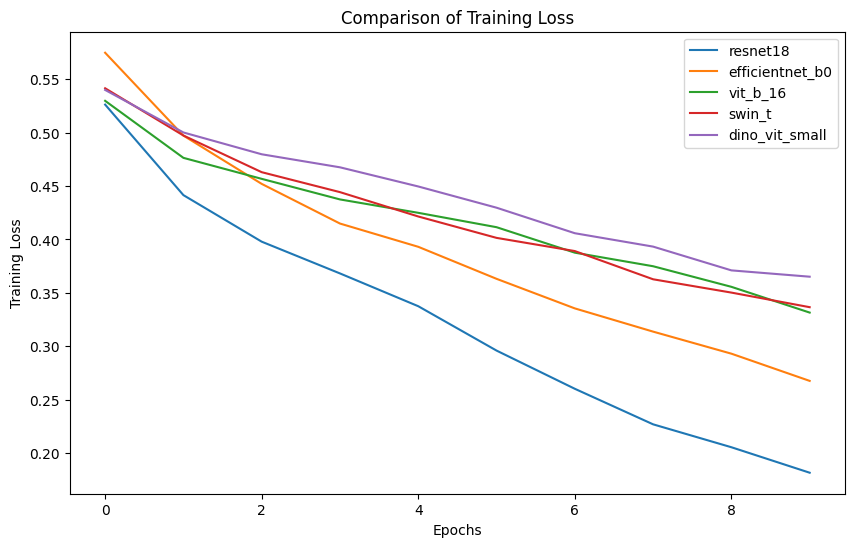

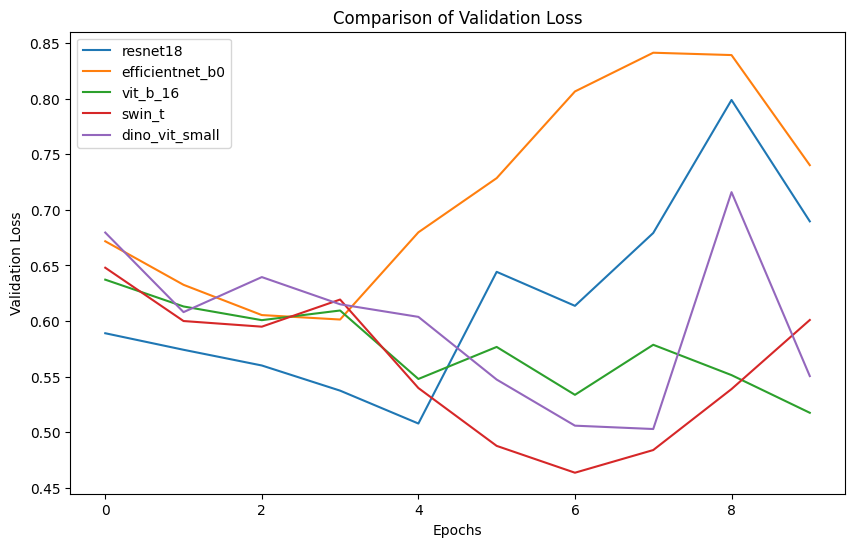

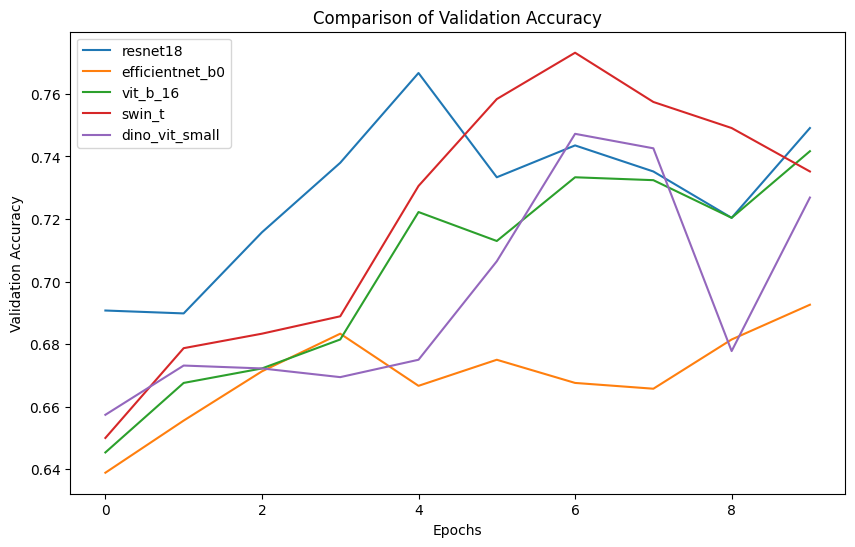

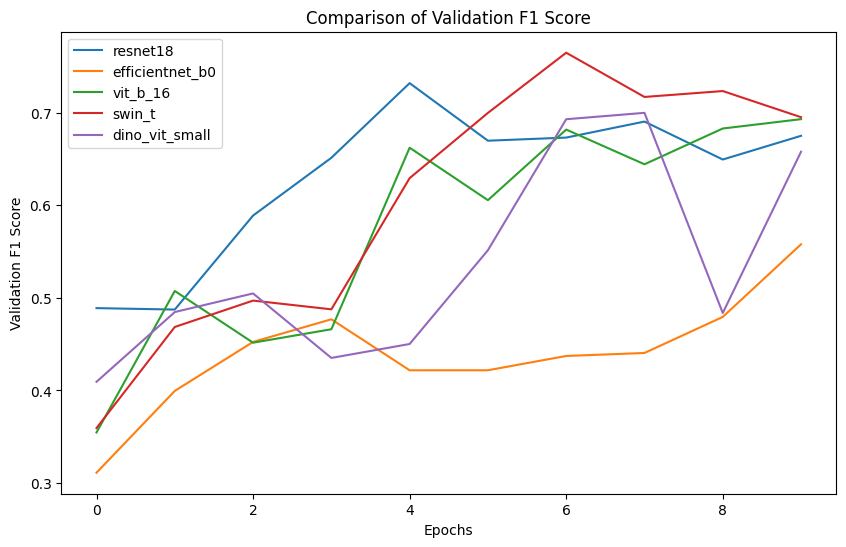

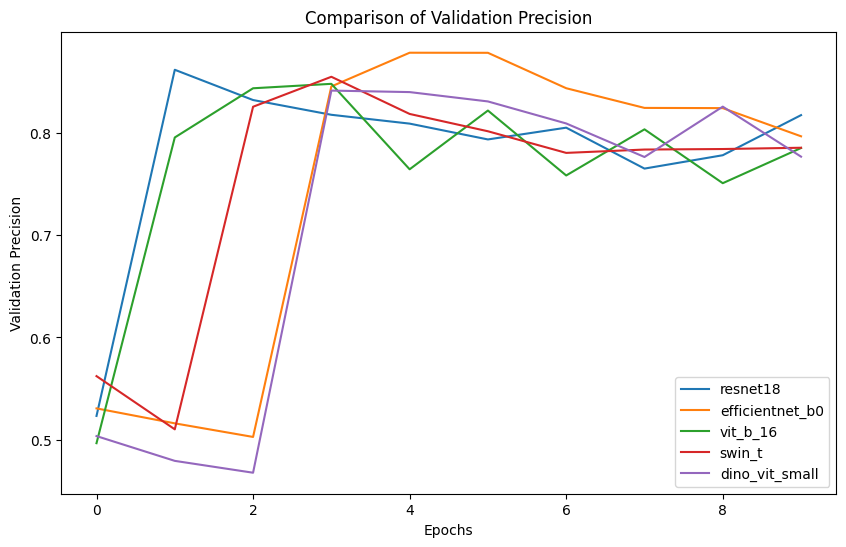

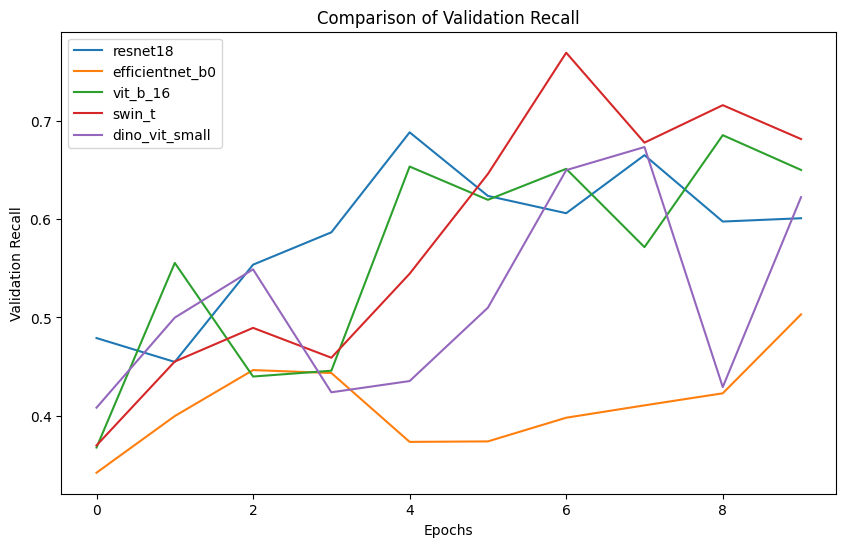

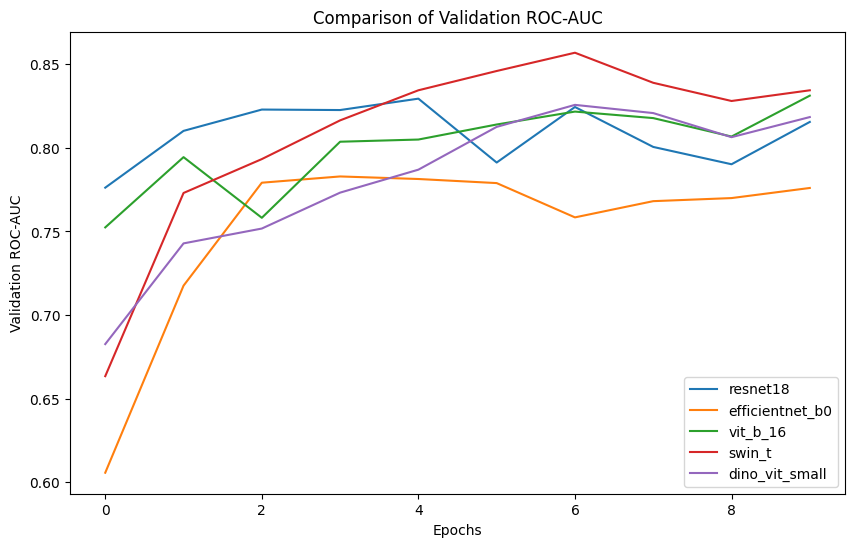

In [11]:
def compare_models(models, train_loader, valid_loader, num_epochs=10, learning_rate=1e-4):
    """
    Train and compare multiple models, tracking metrics for visualization.
    Args:
        models (list): List of model names to compare.
        train_loader (DataLoader): Training DataLoader.
        valid_loader (DataLoader): Validation DataLoader.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate.

    Returns:
        results (dict): Metrics for each model.
    """
    results = {}
    criterion = nn.BCEWithLogitsLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for model_name in models:
        print(f"\n[INFO] Training {model_name}...\n")
        model = create_model(model_name).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Initialize metrics
        model_metrics = {
            "train_loss": [],
            "val_loss": [],
            "val_accuracy": [],
            "val_f1": [],
            "val_precision": [],
            "val_recall": [],
            "val_roc_auc": []
        }

        for epoch in range(num_epochs):
            print(f"\n[INFO] Epoch {epoch + 1}/{num_epochs} for {model_name}")
            
            # Train and validate
            train_loss = train_epoch(model, train_loader, optimizer, criterion, epoch, device)
            val_accuracy, val_loss = valid_epoch(model, valid_loader, criterion, epoch, device)

            # Collect metrics from global lists
            model_metrics["train_loss"].append(train_loss)
            model_metrics["val_loss"].append(val_losses[-1])
            model_metrics["val_accuracy"].append(val_accuracies[-1])
            model_metrics["val_f1"].append(val_f1s[-1])
            model_metrics["val_precision"].append(val_precisions[-1])
            model_metrics["val_recall"].append(val_recalls[-1])
            model_metrics["val_roc_auc"].append(val_roc_aucs[-1])

        # Save metrics for the model
        results[model_name] = model_metrics

    return results

def plot_metrics_comparison(results):
    """
    Plot metrics for all models on shared plots for comparison.
    Args:
        results (dict): Metrics for each model.
    """
    metrics = ["train_loss", "val_loss", "val_accuracy", "val_f1", "val_precision", "val_recall", "val_roc_auc"]
    metric_titles = {
        "train_loss": "Training Loss",
        "val_loss": "Validation Loss",
        "val_accuracy": "Validation Accuracy",
        "val_f1": "Validation F1 Score",
        "val_precision": "Validation Precision",
        "val_recall": "Validation Recall",
        "val_roc_auc": "Validation ROC-AUC"
    }

    for metric in metrics:
        plt.figure(figsize=(10, 6))
        for model_name, model_metrics in results.items():
            plt.plot(model_metrics[metric], label=model_name)
        plt.title(f"Comparison of {metric_titles[metric]}")
        plt.xlabel("Epochs")
        plt.ylabel(metric_titles[metric])
        plt.legend()
        plt.show()

# Specify models to compare
models_to_compare = ["resnet18", "efficientnet_b0", "vit_b_16", "swin_t", "dino_vit_small"]

# Run the comparison
results = compare_models(models_to_compare, train_loader, valid_loader, num_epochs=10)

# Plot metrics
plot_metrics_comparison(results)